In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import regularizers

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
# display results
def plot_results(images, autoencoder):
    plt.figure(figsize=(20, 4))

    n = images.shape[0]
    decoded_imgs = autoencoder.predict(images)

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
# simplest AE model
def build_simple_ae_model(encoding_dim=32, use_regularization=False):
    regularizer = regularizers.l1(10e-5) if use_regularization else None

    input_img = Input(shape=(784,))
    encoded = Dense(encoding_dim, activation='relu',
                    activity_regularizer=regularizer)(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    
    # build decoder
    encoded_input = Input(shape=(encoding_dim, ))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))

    return autoencoder, encoder, decoder

In [5]:
# train the simplest AE model
autoencoder, encoder, decoder = build_simple_ae_model(use_regularization=False)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# train the model
fit_result = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s - loss: 0.3779 - val_loss: 0.2725
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.2648 - val_loss: 0.2536
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.2427 - val_loss: 0.2297
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.2217 - val_loss: 0.2120
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.2071 - val_loss: 0.2000
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.1968 - val_loss: 0.1911
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.1891 - val_loss: 0.1842
Epoch 8/50
60000/60000 [==============================] - 1s - loss: 0.1826 - val_loss: 0.1781
Epoch 9/50
60000/60000 [==============================] - 1s - loss: 0.1769 - val_loss: 0.1729
Epoch 10/50
60000/60000 [==============================] - 1s - loss: 0.1719 - val_loss: 0.1681

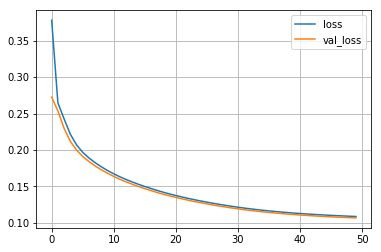

ValueError: cannot reshape array of size 32 into shape (28,28)

In [6]:
# plot losses
plt.plot(fit_result.history['loss'], label='loss')
plt.plot(fit_result.history['val_loss'], label='val_loss')
plt.grid()
plt.legend()
plt.show()

# plot results
plot_results(x_test[np.random.choice(x_test.shape[0], size=15, replace=False), :], encoder)

In [7]:
# train the simplest AE model with regularization
autoencoder, _, _ = build_simple_ae_model(use_regularization=True)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# train the model
fit_result = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s - loss: 0.6837 - val_loss: 0.6607
Epoch 2/100
60000/60000 [==============================] - 1s - loss: 0.6440 - val_loss: 0.6273
Epoch 3/100
60000/60000 [==============================] - 1s - loss: 0.6111 - val_loss: 0.5952
Epoch 4/100
60000/60000 [==============================] - 1s - loss: 0.5802 - val_loss: 0.5655
Epoch 5/100
60000/60000 [==============================] - 1s - loss: 0.5519 - val_loss: 0.5386
Epoch 6/100
60000/60000 [==============================] - 1s - loss: 0.5264 - val_loss: 0.5146
Epoch 7/100
60000/60000 [==============================] - 1s - loss: 0.5037 - val_loss: 0.4932
Epoch 8/100
60000/60000 [==============================] - 1s - loss: 0.4836 - val_loss: 0.4744
Epoch 9/100
60000/60000 [==============================] - 1s - loss: 0.4658 - val_loss: 0.4577
Epoch 10/100
60000/60000 [==============================] - 1s - loss: 0.4501 - val_lo

KeyboardInterrupt: 

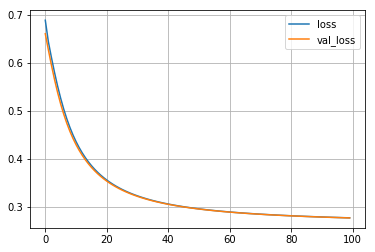

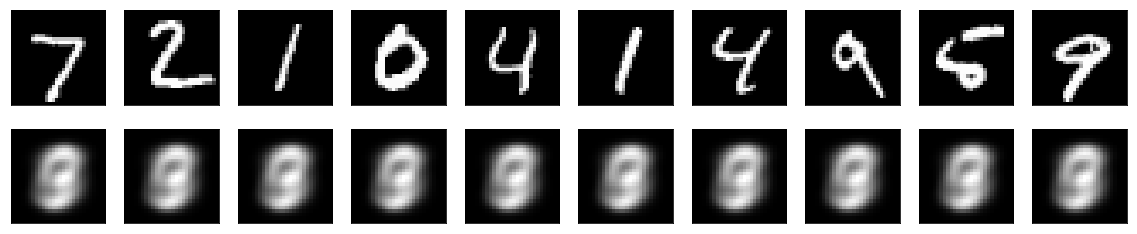

In [8]:
# plot losses
plt.plot(fit_result.history['loss'], label='loss')
plt.plot(fit_result.history['val_loss'], label='val_loss')
plt.grid()
plt.legend()
plt.show()

# plot results
plot_results(x_test[np.random.choice(x_test.shape[0], size=15, replace=False), :], autoencoder)

In [8]:
# deep AE model
def build_deep_ae_model(encoding_dim=32):
    input_img = Input(shape=(784,))
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(64, activation='relu', name='decoder_input')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    
    return Model(input_img, decoded)

In [9]:
autoencoder = build_deep_ae_model()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
print(autoencoder.summary())

# train the model
fit_result = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
decoder_input (Dense)        (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 784)               101136    
Total para

60000/60000 [==============================] - 1s - loss: 0.1056 - val_loss: 0.1046
Epoch 73/100
60000/60000 [==============================] - 1s - loss: 0.1053 - val_loss: 0.1046
Epoch 74/100
60000/60000 [==============================] - 1s - loss: 0.1052 - val_loss: 0.1045
Epoch 75/100
60000/60000 [==============================] - 1s - loss: 0.1048 - val_loss: 0.1045
Epoch 76/100
60000/60000 [==============================] - 1s - loss: 0.1046 - val_loss: 0.1038
Epoch 77/100
60000/60000 [==============================] - 1s - loss: 0.1044 - val_loss: 0.1036
Epoch 78/100
60000/60000 [==============================] - 1s - loss: 0.1041 - val_loss: 0.1035
Epoch 79/100
60000/60000 [==============================] - 1s - loss: 0.1039 - val_loss: 0.1022
Epoch 80/100
60000/60000 [==============================] - 1s - loss: 0.1037 - val_loss: 0.1032
Epoch 81/100
60000/60000 [==============================] - 1s - loss: 0.1036 - val_loss: 0.1031
Epoch 82/100
60000/60000 [=================

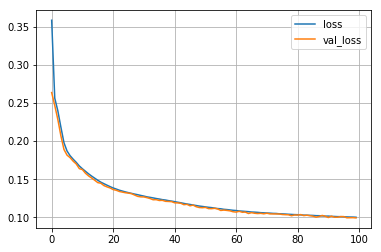

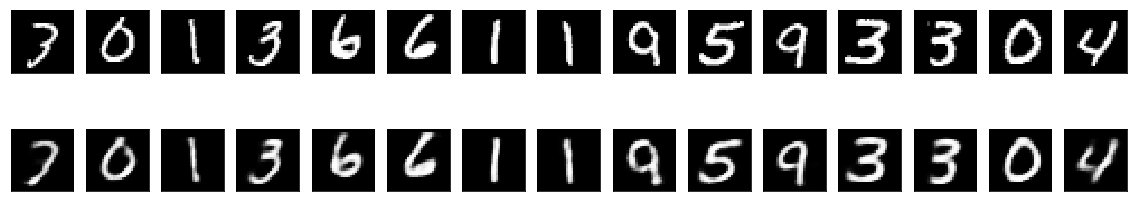

In [11]:
# plot losses
plt.plot(fit_result.history['loss'], label='loss')
plt.plot(fit_result.history['val_loss'], label='val_loss')
plt.grid()
plt.legend()
plt.show()

# plot results
plot_results(x_test[np.random.choice(x_test.shape[0], size=15, replace=False), :], autoencoder)

In [12]:
# convolution AE model
def build_conv_ae_model():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(16, (3, 3), activation='elu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='elu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='elu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(8, (3, 3), activation='elu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_img, decoded)

In [ ]:
autoencoder = build_deep_ae_model()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
print(autoencoder.summary())

# train the model
fit_result = autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
decoder_input (Dense)        (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_14 (Dense)             (None, 784)               101136    
Total para

60000/60000 [==============================] - 1s - loss: 0.1054 - val_loss: 0.1051
Epoch 73/200
60000/60000 [==============================] - 1s - loss: 0.1053 - val_loss: 0.1033
Epoch 74/200
60000/60000 [==============================] - 1s - loss: 0.1050 - val_loss: 0.1035
Epoch 75/200
60000/60000 [==============================] - 1s - loss: 0.1046 - val_loss: 0.1043
Epoch 76/200
60000/60000 [==============================] - 1s - loss: 0.1044 - val_loss: 0.1033
Epoch 77/200
60000/60000 [==============================] - 1s - loss: 0.1041 - val_loss: 0.1031
Epoch 78/200
60000/60000 [==============================] - 1s - loss: 0.1040 - val_loss: 0.1029
Epoch 79/200
60000/60000 [==============================] - 1s - loss: 0.1039 - val_loss: 0.1027
Epoch 80/200
60000/60000 [==============================] - 1s - loss: 0.1035 - val_loss: 0.1027
Epoch 81/200
60000/60000 [==============================] - 1s - loss: 0.1033 - val_loss: 0.1023
Epoch 82/200
60000/60000 [=================

60000/60000 [==============================] - 1s - loss: 0.0941 - val_loss: 0.0938
Epoch 157/200
60000/60000 [==============================] - 1s - loss: 0.0941 - val_loss: 0.0925
Epoch 158/200
60000/60000 [==============================] - 1s - loss: 0.0939 - val_loss: 0.0933
Epoch 159/200
60000/60000 [==============================] - 1s - loss: 0.0939 - val_loss: 0.0931
Epoch 160/200
36352/60000 [=================>............] - ETA: 0s - loss: 0.0938

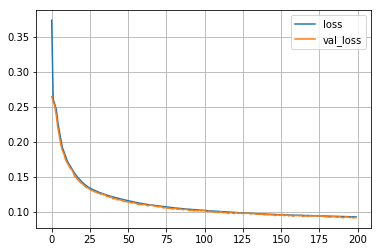

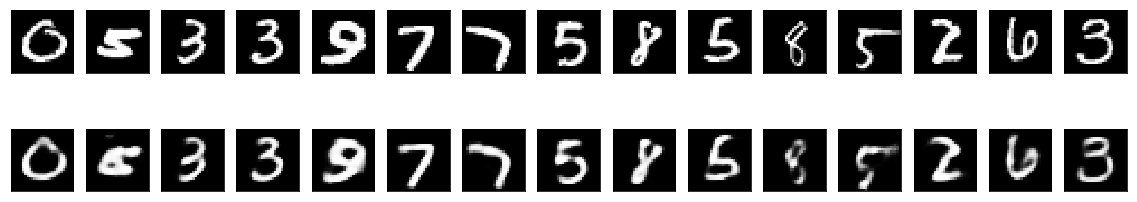

In [53]:
# plot losses
plt.plot(fit_result.history['loss'], label='loss')
plt.plot(fit_result.history['val_loss'], label='val_loss')
plt.grid()
plt.legend()
plt.show()

# plot results
plot_results(x_test[np.random.choice(x_test.shape[0], size=15, replace=False), :], autoencoder)
#plot_results(autoencoder.predict(x_test), n=40)